<a href="https://colab.research.google.com/github/wfsilva-uea/luigi/blob/master/luigi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Oque é ETL?


A coleta dos dados corrobora para o processo de Extract, Transform and Load (ETL), que são as rotinas para extração, transformação e carga dos dados extraídos dos bancos de dados de origem (transacionais) para o “Data Warehouse” (DW). O processo de ETL é a etapa mais importante dentro de processo de BI. É essencial na modelagem da base de dados e faz a conexão entre o operacional e o DW. 

### Por que sua utilização no processo de Ciências dos Dados?


Quando trabalhamos com um grande volume de dados uma ferramenta ETL deve ser utilizada. Utiliza-se da criação de consultas em SQL, de uma forma bem visual, criando componentes que irão automatizar a atualização dos dados, tabelas e visualizações a serem enviados, populando e estruturando do DW.

### Caraterísticas gerais da ferramenta. Vantagem e desvantagem

https://luigi.readthedocs.io/en/stable/

#### Vantagens

*   É Python!
*   Assim, primeiro, você já sabe codificar nele, mais você pode combinar o processo que deseja automatizar (seu código original) com a infraestrutura do pipeline (portanto, Luigi)
*   Sua estrutura “reversa” permite que ele se recupere de tarefas com falha sem executar novamente o pipeline inteiro.
*   Um wrapper de lote AWS para trabalhar diretamente com o Amazon ECS.
*   Possui GUI que mostra o status das tarefas e uma representação gráfica do seu pipeline.

#### Desvantagens

*   É difícil testar.
*   Possui um agendador central que torna difícil paralelizar tarefas.
*   Precisa ser mantido simples, ou melhor, linear (tente mantê-lo <1k tarefas). Muitos nós podem diminuir o tempo de execução de forma incrível.
*   Não há gatilho. Assim, o pipeline não iniciará quando os arquivos necessários estiverem no lugar, mas você precisa configurar um cronjob para verificá-los e fazer o pipeline iniciar

### Desenvolver um exemplo do processo ETL, incluir no exemplo operação de linha, classificação, junção e agregação.

In [2]:
!pip install luigi -q

In [ ]:
!npx degit wfsilva-uea/luigi/northwind.sqlite northwind.sqlite -f
!npx degit wfsilva-uea/luigi/clientes.csv clientes.csv -f

In [86]:
import luigi
import sqlite3
import pandas as pd

In [79]:
# northwind connection
CONNECTION = sqlite3.connect('northwind.sqlite')

In [80]:
# dw connection
DW_CONNECTION = sqlite3.connect('dw.sqlite')

In [81]:
class ProductsTask(luigi.Task):
  
  def output(self):
    return luigi.LocalTarget('products.log')

  def run(self):
    with self.output().open('w') as target:

      sql = """
        select 
          product_id,
          product_name,
          unit_price
        from products
        order by product_name
      """
      df = pd.read_sql_query(sql, CONNECTION)
      df.to_sql('produtos', index=False, con=DW_CONNECTION, if_exists='replace')

      target.write('TUDO OK!')

In [91]:
class OrderTask(luigi.Task):
  
  def requires(self):
    return ProductsTask()

  def output(self):
    return luigi.LocalTarget('orders.log')

  @staticmethod
  def _get_orders():
    sql = """
      select
        o.customer_id,
        od.product_id,
        od.unit_price,
        od.quantity,
        od.discount
      from orders o 
      join order_details od on od.order_id = o.order_id
    """

    df = pd.read_sql_query(sql, CONNECTION)
    df['total'] = (df['unit_price'] * df['quantity'] * (1 - df['discount']) / 100) * 100
    df = df[['customer_id', 'product_id', 'total']]
    df = df.groupby(by=['customer_id', 'product_id']).agg('sum')
    return df.reset_index()

  @staticmethod
  def _get_customers():
    return pd.read_csv('clientes.csv', encoding='utf-8')

  @staticmethod
  def _get_products():
    return pd.read_sql_query('select * from produtos', con=DW_CONNECTION)

  def run(self):
    with self.output().open('w') as target:
      df_orders = self._get_orders()
      df_customers = self._get_customers()
      df_orders = pd.merge(df_orders, df_customers, left_on=['customer_id'], right_on=['customer_id'])    
      
      df_products = self._get_products()
      df_orders = pd.merge(df_orders, df_products, left_on=['product_id'], right_on=['product_id'])

      # storing orders
      df_orders.to_sql('pedidos', index=False, con=DW_CONNECTION, if_exists='replace')

      target.write('TUDO OK!')

In [93]:
# run luigi as local scheduler
luigi.build([OrderTask()], local_scheduler=True)

DEBUG: Checking if OrderTask() is complete
DEBUG: Checking if ProductsTask() is complete
INFO: Informed scheduler that task   OrderTask__99914b932b   has status   PENDING
INFO: Informed scheduler that task   ProductsTask__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 56] Worker Worker(salt=797362464, workers=1, host=a1eab9a047fd, username=root, pid=56) running   OrderTask()
INFO: [pid 56] Worker Worker(salt=797362464, workers=1, host=a1eab9a047fd, username=root, pid=56) done      OrderTask()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   OrderTask__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=797362464, workers=1, host=a1eab9a047fd, username=root, pid=56) was stopped. Shutting down Keep-Alive thread
INFO: 
===== 

True

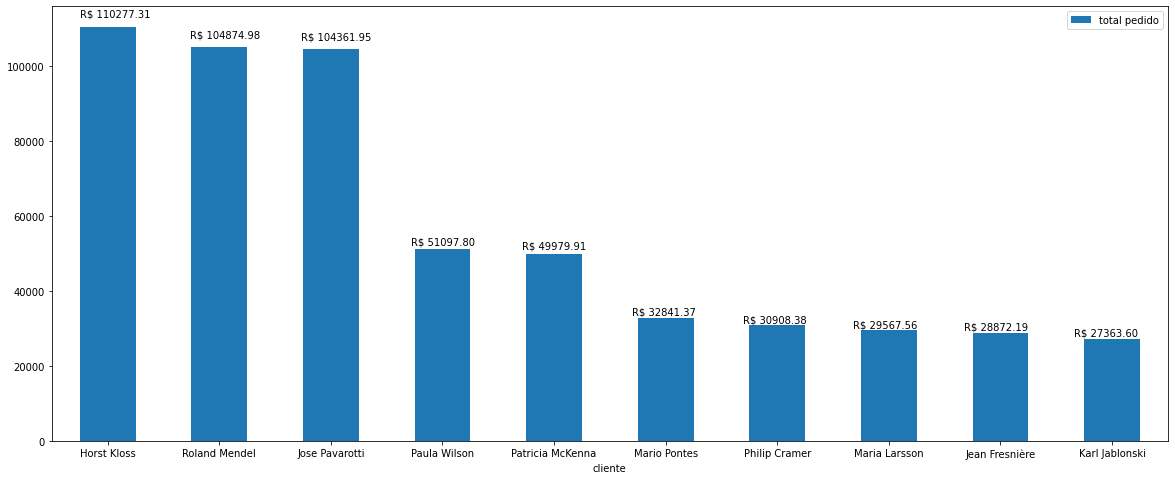

In [94]:
sql = """
  select
    p.contact_name as cliente,
    sum(p.total) as 'total pedido'
  from pedidos p
  group by p.contact_name
  order by total desc
"""
df = pd.read_sql_query(sql, conn_dw)
df = df.sort_values(by='total pedido', ascending=False)

ax = df.head(10).plot.bar(x='cliente', y='total pedido', rot=0, figsize=(20, 8))
for p in ax.patches:
    ax.annotate('R$ %.2f' % p.get_height(), (p.get_x() * .99, p.get_height() * 1.025))